# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import spacy
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Dowanload and load catalan stopwords from `spacy`.

In [2]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 23.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'llavors', 'nostres', 'baix', 'jo', 'no', 'mons', 'la', 'algun', 'dins', 'vostres', 'vaig', 'ha', 'qui', 'ambdós', 'saps', "s'ha", 'altra', 'aquells', 'aquí', 'ho', 'el', 'estaven', 'mateix', 'ses', 'teva', 'ací', 'tota', 'oh', 'cadascú', 'semblant', 'va', 'està', 'ton', 'al', 'havia', 'van', 'has', 'veu', 'a', 'les', 'cadascunes', 'oi', 'què', 'quins', 'saben', 'consigueix', 'cadascuna', 'tots', 'poques', 'alguna', 'molts', 'tantes', 'tot', 'ells', 'sobre', 'bé', 'eh', 'mal', 'anar', 'era', "n'he", 'primer', 'sense', 'apa', 'de', 'tene', 'nostre', 'vosaltres', 'quan', 'us', 'que', 'esta', 'abans', 'elles', 'és', 'del', 'només', "s'han", 'sobretot', 'tampoc', 'ens', 'tant', 'altres', 'potser', 'poca', 'sa', 'vas', 'donat', 'aquesta', 'ja', 'he', 'pel', 'i', 'heu', 'dintre', 'contra', 'són', 'erem

# Load and process csv data

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
texts = data['text']
labels = data['class']
year = data['year']

In [5]:
type(labels)

pandas.core.series.Series

## Remove stopwords + leading and trailing quotes

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(preprocess_text(sentence))

In [7]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

['notificaci resoluci duns processos dinscripci dadjudicaci registre sollicitants dhabitatge protecci oficial barcelona'
 'aprovaci preu pblic catleg utopies persistents collecci dart contemporani museu granollers'
 'notificaci dactes trmit resoluci dexpedients sancionadors recursos reposici'
 'bases regir convocatria concurs cobrir lloc treball dassessor jurdic departament seguretat ciutadana rgim inter'
 'nomenament funcionari inter laboral substituci'
 'licitaci contracte serveis prstec entitats io collectius vaixella reutilitzable propietat lajuntament collectius io entitats participaci ciutadana'
 'decret dalcaldia competncies lrea poltica social rea salut'
 'aprovaci loferta pblica docupaci'
 'resoluci dun expedient baixa dofici padr municipal dhabitants'
 'aprovaci inicial modificaci lordenana convivencia ciutadana'
 'pla econmic financer' 'aprovaci inicial tres projectes dobra ordinria'
 'aprovaci definitiva projecte renovaci integral sistema climatitzaci lateneu sant celoni'
 

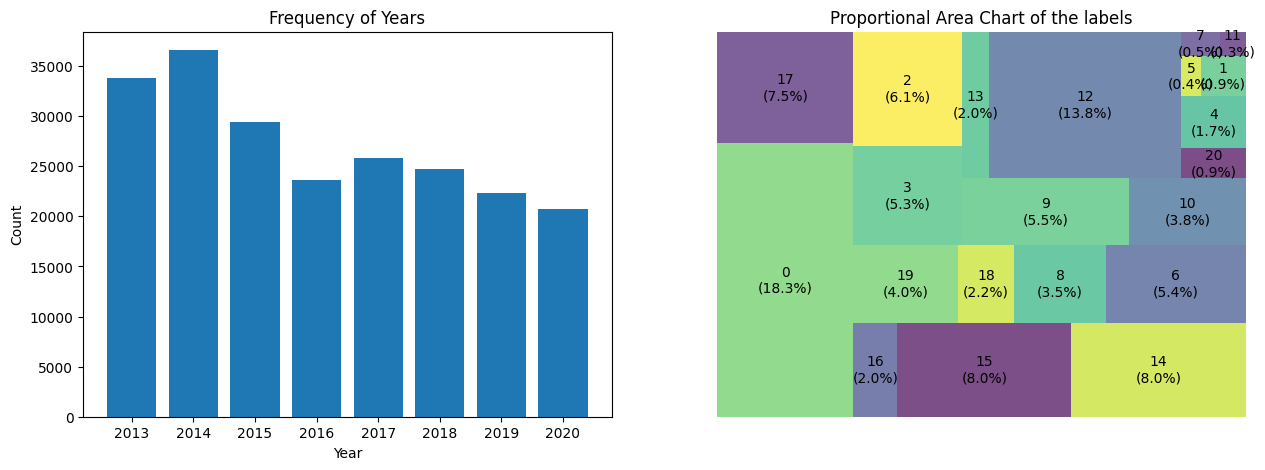

In [8]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Convert texts to TF-IDF vectors

In [9]:
vectorizer = TfidfVectorizer(max_features=1000)

### How many unique words are in texts?

In [10]:
test_vectorizer = TfidfVectorizer()
test_vectorizer.fit(preprocessed_texts)
print(f"Total unique words in corpus: {len(test_vectorizer.vocabulary_)}")

Total unique words in corpus: 26735


In [11]:
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [9]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [12]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [13]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

## Training and Testing

In [14]:
def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

## History plot

In [10]:
def plot_history(n_epochs, history):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("Training Loss and Accuracy")

    # Accuracy plot
    ax1.plot(np.arange(n_epochs), history["train_accuracy"], label="train")
    ax1.plot(np.arange(n_epochs), history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(loc="lower right")

    # Loss plot
    ax2.plot(np.arange(n_epochs), history["train_loss"],     label="train")
    ax2.plot(np.arange(n_epochs), history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

## Fitting function

In [11]:
def fit(model, train_loader, test_loader, optimizer, epochs):
    history = {k: [] for k in ["train_loss", "train_accuracy", "val_loss", "val_accuracy"]}

    for epoch in range(epochs):
        train(model, train_loader, optimizer, history)
        test(model,  test_loader,  history)

        print(f"Epoch {epoch+1:02d}/{epochs} │ "
              f"loss={history['train_loss'][-1]:.4f}  "
              f"val_loss={history['val_loss'][-1]:.4f}  "
              f"acc={history['train_accuracy'][-1]:.2f}%  "
              f"val_acc={history['val_accuracy'][-1]:.2f}%")

    plot_history(epochs, history)
    return history

## Run model

Epoch 01/20 │ loss=0.2980  val_loss=0.1846  acc=91.75%  val_acc=94.45%
Epoch 02/20 │ loss=0.1660  val_loss=0.1743  acc=94.84%  val_acc=94.80%
Epoch 03/20 │ loss=0.1463  val_loss=0.1720  acc=95.33%  val_acc=94.72%
Epoch 04/20 │ loss=0.1309  val_loss=0.1675  acc=95.82%  val_acc=95.02%
Epoch 05/20 │ loss=0.1169  val_loss=0.1693  acc=96.21%  val_acc=95.02%
Epoch 06/20 │ loss=0.1045  val_loss=0.1684  acc=96.61%  val_acc=95.10%
Epoch 07/20 │ loss=0.0927  val_loss=0.1739  acc=96.98%  val_acc=95.02%
Epoch 08/20 │ loss=0.0827  val_loss=0.1746  acc=97.30%  val_acc=95.17%
Epoch 09/20 │ loss=0.0737  val_loss=0.1823  acc=97.59%  val_acc=95.15%
Epoch 10/20 │ loss=0.0652  val_loss=0.1879  acc=97.88%  val_acc=95.01%
Epoch 11/20 │ loss=0.0587  val_loss=0.1944  acc=98.05%  val_acc=95.09%
Epoch 12/20 │ loss=0.0530  val_loss=0.1991  acc=98.20%  val_acc=95.09%
Epoch 13/20 │ loss=0.0485  val_loss=0.2059  acc=98.38%  val_acc=95.15%
Epoch 14/20 │ loss=0.0444  val_loss=0.2138  acc=98.50%  val_acc=95.06%
Epoch 

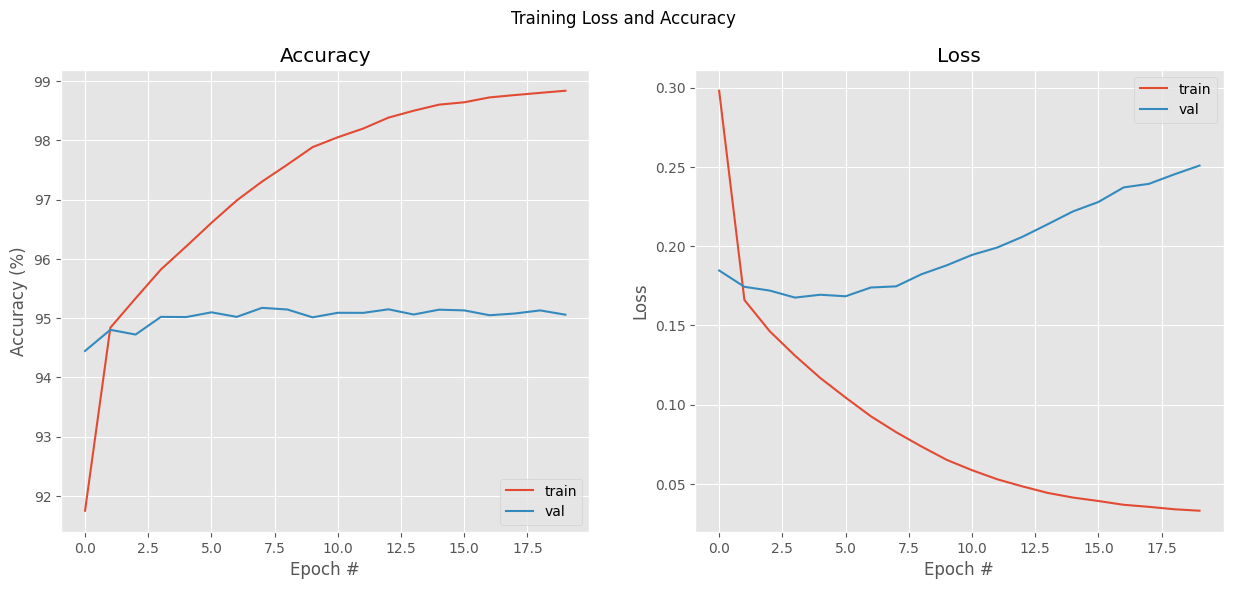

In [19]:
history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

There are clear overfitting issues with this model.

# Transformer model

In [20]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate

/mnt/d/MEGA/MÀSTER MODELLING/2 - Mathematics for Big Data/3. DeepLearning/MBD_NN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-10 21:55:12.888285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749585312.951648   18746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749585312.969007   18746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749585313.108672   18746 computation_placer.cc:177] computation placer already registered. Please check

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [34]:
df = pd.DataFrame({
    "text": preprocessed_texts,
    "label": labels
})

train_tok, test_tok = train_test_split(df, test_size=0.25,
                                       stratify=labels, random_state=0)

train_tok = Dataset.from_pandas(train_tok)
test_tok   = Dataset.from_pandas(test_tok)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
# train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
# test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_tok.map(tokenize)
test_tok  = test_tok.map(tokenize)

train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 54244/54244 [00:10<00:00, 5329.54 examples/s]


APUNTAR EN EL PPT QUÈ MERDES ÉS EL BERT-BASE-UNCASED:

- **BERT** stands for **Bidirectional Encoder Representations from Transformers**.

- It’s a pretrained Transformer-based model developed by Google in 2018.

- Designed to understand language **bidirectionally** (looking at context from both left and right).

- `"base"` means it’s the smaller version of BERT (compared to `bert-large`).

- `"uncased"` means it does not distinguish uppercase and lowercase letters — input text is lowercased before tokenization.


When to Use:
- Great general-purpose language model.

- Lowercased text input, so works best on texts that are not case-sensitive.

- Efficient enough for many applications while maintaining strong performance.

Model Specs:

| Feature                | Description                 |
|------------------------|-----------------------------|
| Layers (Transformer blocks) | 12                      |
| Hidden size            | 768                         |
| Attention heads        | 12                          |
| Parameters             | ~110 million                |
| Vocabulary size        | 30,522 tokens               |
| Max input length       | 512 tokens                  |

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer wrapping (so it can be used as a sklearn-like model)

In [38]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir=".outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    num_train_epochs=2,           # 2-3 epochs usually fine when fine-tuning
    fp16=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Run model

In [39]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.211900,0.201387,0.954742
2,0.147700,0.162076,0.963093


{'eval_loss': 0.16207608580589294,
 'eval_accuracy': 0.9630926922793305,
 'eval_runtime': 136.7285,
 'eval_samples_per_second': 396.728,
 'eval_steps_per_second': 49.595,
 'epoch': 2.0}

FINAL NOTES: since the transformer model DOES NOT perform better than the FCNN, we will modify the FCNN in order to reduce the overfitting issue. We will also try training using per-year data and see its performance when predicting the following year data.

# FCNN: Dealing with overfitting

## Adding Dropout layer and Batch Normalization

`Dropout` randomly disables some neurons during training, forcing the model to generalize better whereas `Batch Normalization` helps in stabilizing and regularizing the training, especially in deeper networks.

In [12]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        return out

Epoch 01/20 │ loss=0.3539  val_loss=0.1907  acc=90.45%  val_acc=94.40%
Epoch 02/20 │ loss=0.2427  val_loss=0.1820  acc=93.10%  val_acc=94.66%
Epoch 03/20 │ loss=0.2209  val_loss=0.1761  acc=93.56%  val_acc=94.83%
Epoch 04/20 │ loss=0.2052  val_loss=0.1711  acc=93.92%  val_acc=94.98%
Epoch 05/20 │ loss=0.1932  val_loss=0.1701  acc=94.28%  val_acc=94.97%
Epoch 06/20 │ loss=0.1849  val_loss=0.1677  acc=94.42%  val_acc=95.04%
Epoch 07/20 │ loss=0.1802  val_loss=0.1671  acc=94.58%  val_acc=95.05%
Epoch 08/20 │ loss=0.1715  val_loss=0.1686  acc=94.76%  val_acc=95.09%
Epoch 09/20 │ loss=0.1676  val_loss=0.1643  acc=94.87%  val_acc=95.24%
Epoch 10/20 │ loss=0.1635  val_loss=0.1657  acc=95.03%  val_acc=95.23%
Epoch 11/20 │ loss=0.1584  val_loss=0.1640  acc=95.19%  val_acc=95.28%
Epoch 12/20 │ loss=0.1545  val_loss=0.1689  acc=95.22%  val_acc=95.25%
Epoch 13/20 │ loss=0.1518  val_loss=0.1639  acc=95.28%  val_acc=95.31%
Epoch 14/20 │ loss=0.1505  val_loss=0.1664  acc=95.33%  val_acc=95.31%
Epoch 

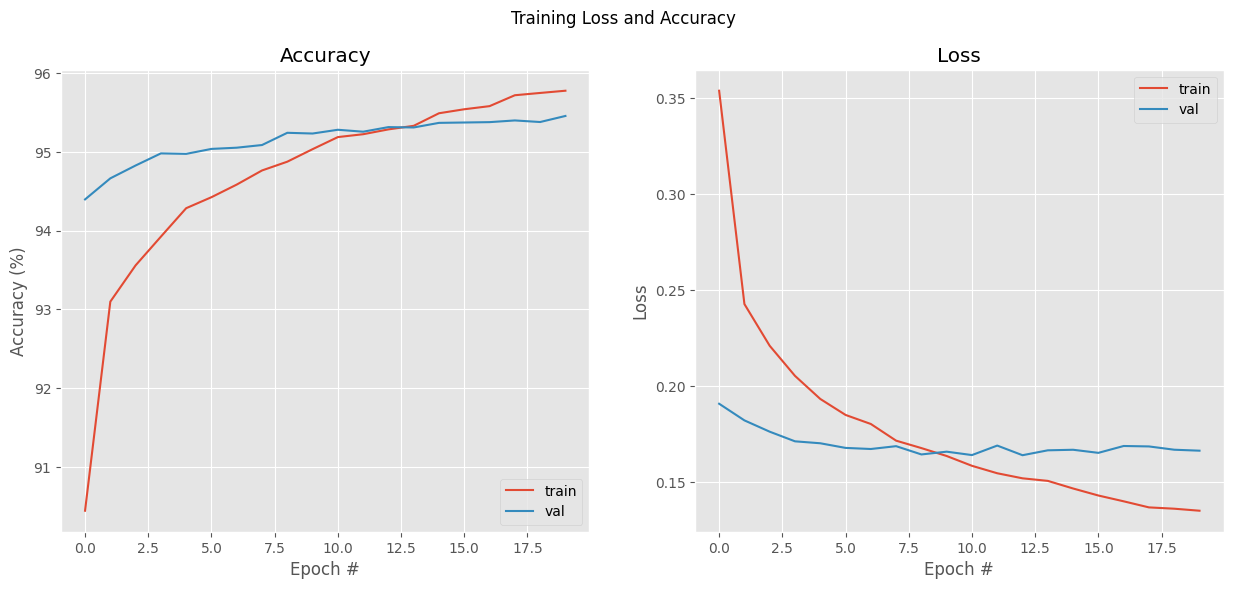

In [22]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 10
)

We can see the overfitting has improved at the cost of reducing slightly the training accuracy of the model: 98,91 -> 95,84. 

The validation (test) accuracy improves though: 95,21 -> 95,38

## Yearly data distribution for train and testing

Now we will use data from a specific year as the validation set, and data from the previous year as the training set. This approach helps estimate the model’s predictive power on future (unseen) data, simulating how it might perform on the final test set.

Notice we define the vectorizer and the fcnn outside the loop. 1. We are fiting the vectorizer with the entire preprocess data. 2. The fcnn has its weights improved in each year.

### Define max_eatures for the vectorizer (and input_size for the FCNN) as 10000 (~30% of all the unique words in preprocessed data)

`train` and `test` functions are modified so they can be run on GPU.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:

        # Modifications to send data to GPU
        data = data.to(device).float()
        target = target.to(device).long()
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:

            # Modifications to send data to GPU
            data = data.to(device).float()
            target = target.to(device).long()
            
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

Length Traing data: 33770
Length Test data: 36589
Epoch 01/20 │ loss=0.5157  val_loss=0.2909  acc=86.38%  val_acc=92.09%
Epoch 02/20 │ loss=0.2461  val_loss=0.2776  acc=93.12%  val_acc=92.54%
Epoch 03/20 │ loss=0.2071  val_loss=0.2591  acc=93.94%  val_acc=93.02%
Epoch 04/20 │ loss=0.1814  val_loss=0.2643  acc=94.63%  val_acc=93.16%
Epoch 05/20 │ loss=0.1643  val_loss=0.2716  acc=94.99%  val_acc=92.97%
Epoch 06/20 │ loss=0.1511  val_loss=0.2783  acc=95.43%  val_acc=93.06%
Epoch 07/20 │ loss=0.1387  val_loss=0.2894  acc=95.66%  val_acc=92.94%
Epoch 08/20 │ loss=0.1296  val_loss=0.3024  acc=95.96%  val_acc=92.78%
Epoch 09/20 │ loss=0.1270  val_loss=0.2968  acc=96.01%  val_acc=92.92%
Epoch 10/20 │ loss=0.1147  val_loss=0.3079  acc=96.48%  val_acc=93.07%
Epoch 11/20 │ loss=0.1144  val_loss=0.3092  acc=96.43%  val_acc=92.89%
Epoch 12/20 │ loss=0.1083  val_loss=0.3091  acc=96.54%  val_acc=93.13%
Epoch 13/20 │ loss=0.1050  val_loss=0.3228  acc=96.64%  val_acc=92.84%
Epoch 14/20 │ loss=0.1010  

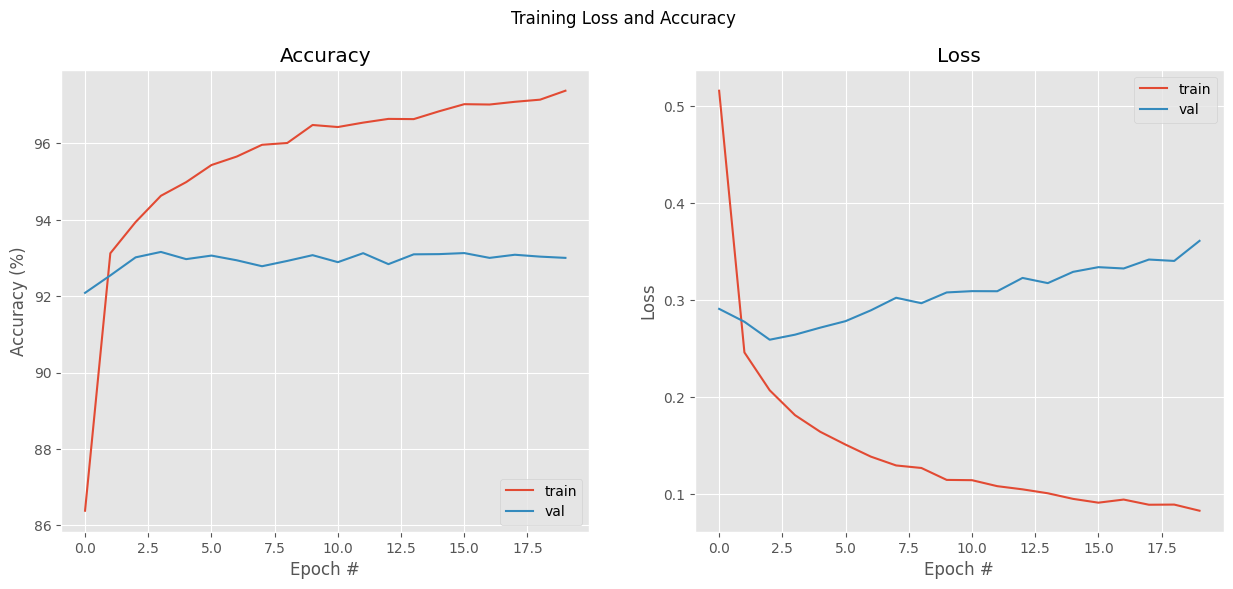

Length Traing data: 70359
Length Test data: 29412
Epoch 01/20 │ loss=0.2168  val_loss=0.2933  acc=94.24%  val_acc=92.13%
Epoch 02/20 │ loss=0.1718  val_loss=0.2623  acc=94.91%  val_acc=92.89%
Epoch 03/20 │ loss=0.1545  val_loss=0.2523  acc=95.22%  val_acc=93.13%
Epoch 04/20 │ loss=0.1455  val_loss=0.2623  acc=95.50%  val_acc=92.99%
Epoch 05/20 │ loss=0.1406  val_loss=0.2566  acc=95.54%  val_acc=92.93%
Epoch 06/20 │ loss=0.1306  val_loss=0.2798  acc=95.81%  val_acc=92.79%
Epoch 07/20 │ loss=0.1307  val_loss=0.2585  acc=95.78%  val_acc=93.01%
Epoch 08/20 │ loss=0.1241  val_loss=0.2564  acc=96.00%  val_acc=93.44%
Epoch 09/20 │ loss=0.1241  val_loss=0.2611  acc=96.06%  val_acc=93.26%
Epoch 10/20 │ loss=0.1173  val_loss=0.2792  acc=96.17%  val_acc=93.27%
Epoch 11/20 │ loss=0.1157  val_loss=0.2778  acc=96.21%  val_acc=93.34%
Epoch 12/20 │ loss=0.1126  val_loss=0.2732  acc=96.31%  val_acc=93.37%
Epoch 13/20 │ loss=0.1104  val_loss=0.2747  acc=96.40%  val_acc=93.18%
Epoch 14/20 │ loss=0.1098  

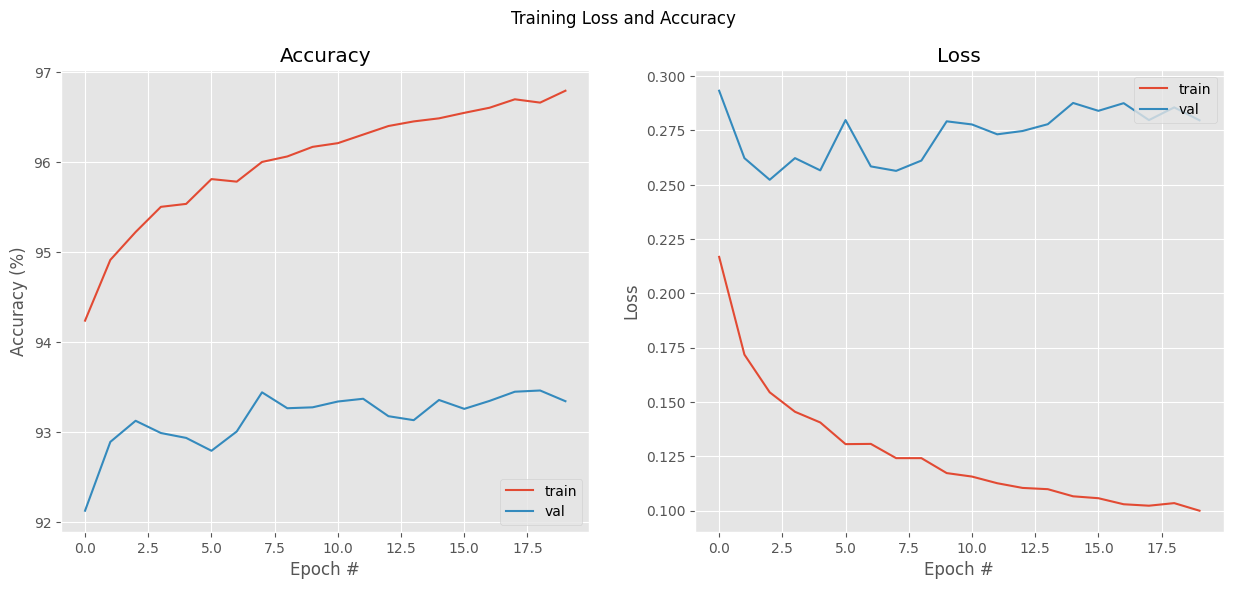

Length Traing data: 99771
Length Test data: 23589
Epoch 01/20 │ loss=0.1640  val_loss=0.2399  acc=95.35%  val_acc=93.68%
Epoch 02/20 │ loss=0.1414  val_loss=0.2409  acc=95.72%  val_acc=93.62%
Epoch 03/20 │ loss=0.1353  val_loss=0.2447  acc=95.83%  val_acc=93.75%
Epoch 04/20 │ loss=0.1299  val_loss=0.2392  acc=95.97%  val_acc=93.91%
Epoch 05/20 │ loss=0.1237  val_loss=0.2488  acc=96.12%  val_acc=93.82%
Epoch 06/20 │ loss=0.1211  val_loss=0.2557  acc=96.18%  val_acc=93.68%
Epoch 07/20 │ loss=0.1190  val_loss=0.2514  acc=96.18%  val_acc=93.93%
Epoch 08/20 │ loss=0.1171  val_loss=0.2584  acc=96.24%  val_acc=93.82%
Epoch 09/20 │ loss=0.1152  val_loss=0.2579  acc=96.33%  val_acc=93.75%
Epoch 10/20 │ loss=0.1134  val_loss=0.2622  acc=96.36%  val_acc=93.79%
Epoch 11/20 │ loss=0.1096  val_loss=0.2640  acc=96.45%  val_acc=93.82%
Epoch 12/20 │ loss=0.1105  val_loss=0.2616  acc=96.49%  val_acc=93.97%
Epoch 13/20 │ loss=0.1067  val_loss=0.2664  acc=96.54%  val_acc=93.88%
Epoch 14/20 │ loss=0.1074  

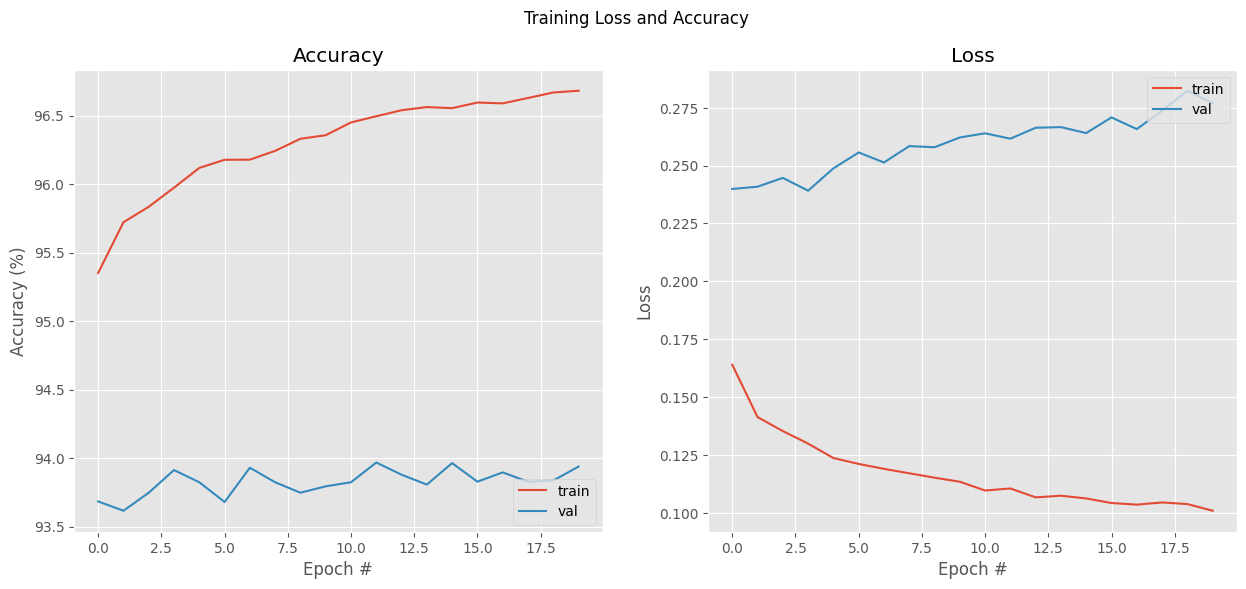

Length Traing data: 123360
Length Test data: 25813
Epoch 01/20 │ loss=0.1444  val_loss=0.2154  acc=95.86%  val_acc=94.56%
Epoch 02/20 │ loss=0.1324  val_loss=0.2057  acc=96.02%  val_acc=94.64%
Epoch 03/20 │ loss=0.1249  val_loss=0.2057  acc=96.13%  val_acc=94.84%
Epoch 04/20 │ loss=0.1231  val_loss=0.2027  acc=96.25%  val_acc=94.96%
Epoch 05/20 │ loss=0.1207  val_loss=0.2092  acc=96.27%  val_acc=94.87%
Epoch 06/20 │ loss=0.1186  val_loss=0.2120  acc=96.32%  val_acc=94.95%
Epoch 07/20 │ loss=0.1167  val_loss=0.2086  acc=96.29%  val_acc=94.78%
Epoch 08/20 │ loss=0.1151  val_loss=0.2175  acc=96.34%  val_acc=94.87%
Epoch 09/20 │ loss=0.1132  val_loss=0.2172  acc=96.39%  val_acc=94.92%
Epoch 10/20 │ loss=0.1119  val_loss=0.2143  acc=96.46%  val_acc=94.87%
Epoch 11/20 │ loss=0.1113  val_loss=0.2148  acc=96.47%  val_acc=94.90%
Epoch 12/20 │ loss=0.1082  val_loss=0.2244  acc=96.48%  val_acc=94.86%
Epoch 13/20 │ loss=0.1085  val_loss=0.2196  acc=96.47%  val_acc=94.88%
Epoch 14/20 │ loss=0.1072 

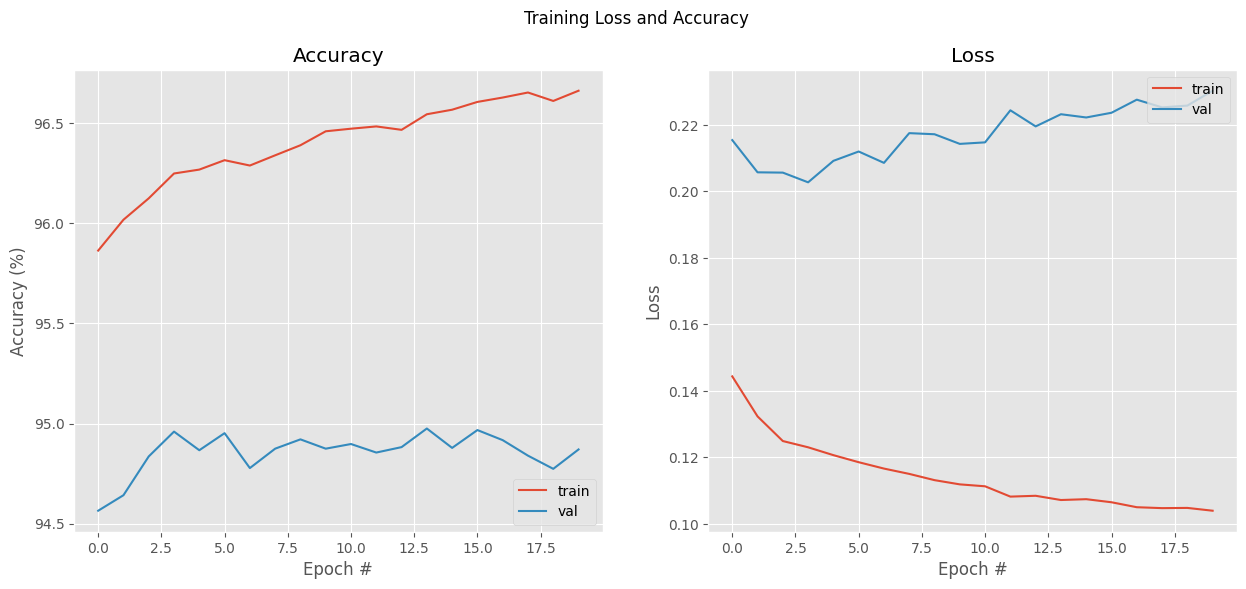

Length Traing data: 149173
Length Test data: 24734
Epoch 01/20 │ loss=0.1363  val_loss=0.2212  acc=96.06%  val_acc=94.35%
Epoch 02/20 │ loss=0.1299  val_loss=0.2207  acc=96.11%  val_acc=94.45%
Epoch 03/20 │ loss=0.1234  val_loss=0.2175  acc=96.27%  val_acc=94.45%
Epoch 04/20 │ loss=0.1222  val_loss=0.2200  acc=96.21%  val_acc=94.60%
Epoch 05/20 │ loss=0.1207  val_loss=0.2204  acc=96.26%  val_acc=94.55%
Epoch 06/20 │ loss=0.1186  val_loss=0.2172  acc=96.39%  val_acc=94.63%
Epoch 07/20 │ loss=0.1163  val_loss=0.2191  acc=96.39%  val_acc=94.67%
Epoch 08/20 │ loss=0.1152  val_loss=0.2223  acc=96.38%  val_acc=94.51%
Epoch 09/20 │ loss=0.1128  val_loss=0.2197  acc=96.44%  val_acc=94.56%
Epoch 10/20 │ loss=0.1130  val_loss=0.2244  acc=96.48%  val_acc=94.61%
Epoch 11/20 │ loss=0.1118  val_loss=0.2225  acc=96.45%  val_acc=94.64%
Epoch 12/20 │ loss=0.1110  val_loss=0.2263  acc=96.53%  val_acc=94.72%
Epoch 13/20 │ loss=0.1096  val_loss=0.2298  acc=96.57%  val_acc=94.65%
Epoch 14/20 │ loss=0.1092 

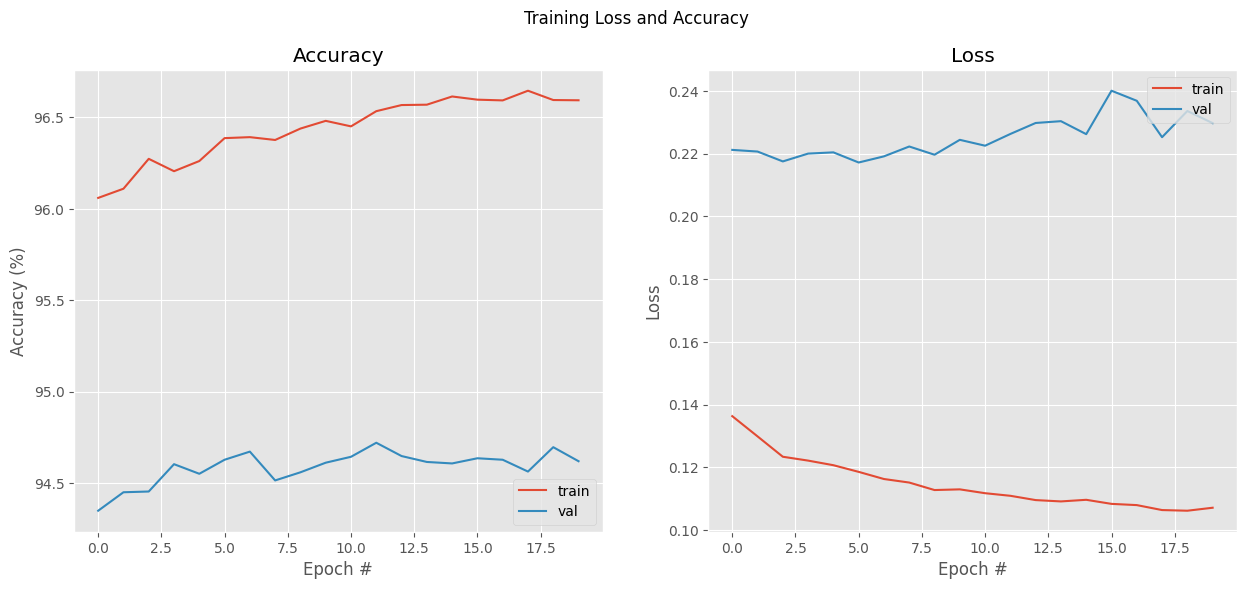

Length Traing data: 173907
Length Test data: 22365
Epoch 01/20 │ loss=0.1322  val_loss=0.1982  acc=96.15%  val_acc=94.69%
Epoch 02/20 │ loss=0.1273  val_loss=0.1923  acc=96.20%  val_acc=95.00%
Epoch 03/20 │ loss=0.1245  val_loss=0.1965  acc=96.22%  val_acc=95.08%
Epoch 04/20 │ loss=0.1215  val_loss=0.1911  acc=96.30%  val_acc=95.08%
Epoch 05/20 │ loss=0.1223  val_loss=0.1863  acc=96.23%  val_acc=95.30%
Epoch 06/20 │ loss=0.1184  val_loss=0.1899  acc=96.33%  val_acc=95.18%
Epoch 07/20 │ loss=0.1188  val_loss=0.1941  acc=96.31%  val_acc=95.22%
Epoch 08/20 │ loss=0.1172  val_loss=0.1887  acc=96.40%  val_acc=95.32%
Epoch 09/20 │ loss=0.1154  val_loss=0.1869  acc=96.40%  val_acc=95.36%
Epoch 10/20 │ loss=0.1132  val_loss=0.1905  acc=96.51%  val_acc=95.21%
Epoch 11/20 │ loss=0.1142  val_loss=0.1896  acc=96.42%  val_acc=95.28%
Epoch 12/20 │ loss=0.1128  val_loss=0.1974  acc=96.50%  val_acc=95.26%
Epoch 13/20 │ loss=0.1118  val_loss=0.2029  acc=96.49%  val_acc=95.13%
Epoch 14/20 │ loss=0.1115 

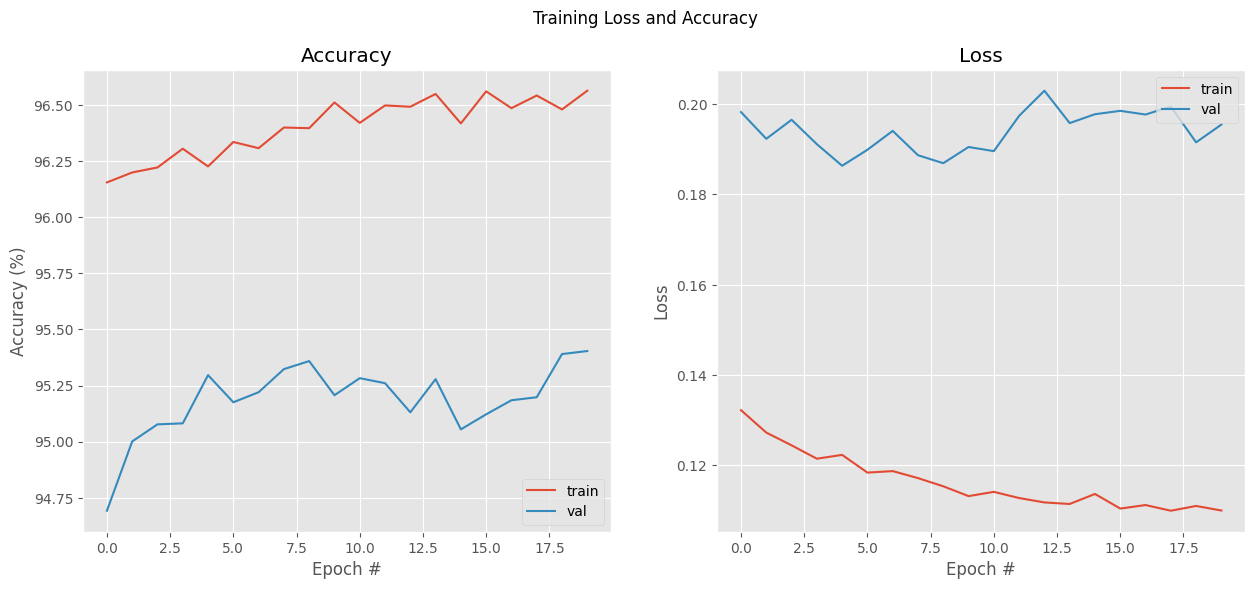

Length Traing data: 196272
Length Test data: 20702
Epoch 01/20 │ loss=0.1253  val_loss=0.2908  acc=96.27%  val_acc=93.91%
Epoch 02/20 │ loss=0.1254  val_loss=0.3000  acc=96.25%  val_acc=93.85%
Epoch 03/20 │ loss=0.1213  val_loss=0.2834  acc=96.35%  val_acc=93.94%
Epoch 04/20 │ loss=0.1206  val_loss=0.2951  acc=96.33%  val_acc=94.00%
Epoch 05/20 │ loss=0.1190  val_loss=0.2869  acc=96.32%  val_acc=93.98%
Epoch 06/20 │ loss=0.1185  val_loss=0.2897  acc=96.41%  val_acc=94.07%
Epoch 07/20 │ loss=0.1172  val_loss=0.2916  acc=96.37%  val_acc=93.99%
Epoch 08/20 │ loss=0.1162  val_loss=0.3032  acc=96.40%  val_acc=94.00%
Epoch 09/20 │ loss=0.1172  val_loss=0.2842  acc=96.37%  val_acc=94.00%
Epoch 10/20 │ loss=0.1153  val_loss=0.2979  acc=96.46%  val_acc=93.99%
Epoch 11/20 │ loss=0.1143  val_loss=0.2971  acc=96.43%  val_acc=93.95%
Epoch 12/20 │ loss=0.1153  val_loss=0.3030  acc=96.47%  val_acc=94.08%
Epoch 13/20 │ loss=0.1133  val_loss=0.2998  acc=96.47%  val_acc=94.02%
Epoch 14/20 │ loss=0.1135 

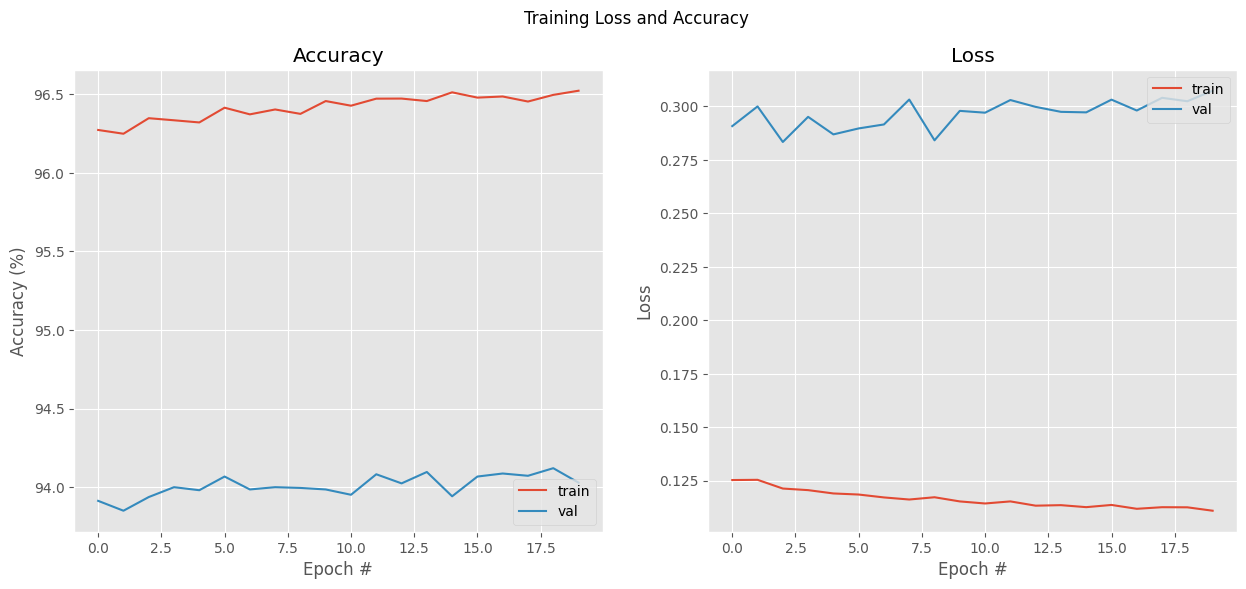

In [16]:
year_num = 2014
val_acc_history = {}

vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(preprocessed_texts)

fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

while year_num <= 2020:

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y < year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ < year_num])
    print(f'Length Traing data: {len(y)}')
    train_dataset = DataLoader(TextDataset(X, y), batch_size=32, shuffle=True)

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y == year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ == year_num])
    print(f'Length Test data: {len(y)}')    
    test_dataset = DataLoader(TextDataset(X, y), batch_size=32)

    history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
    )

    val_acc_history[year_num] = history['val_accuracy'][-1]

    year_num += 1

In [18]:
val_acc_history

{2014: 93.0033616660745,
 2015: 93.34285325717394,
 2016: 93.9378523888253,
 2017: 94.87080153411073,
 2018: 94.61874343009623,
 2019: 95.40353230494075,
 2020: 94.02956236112453}

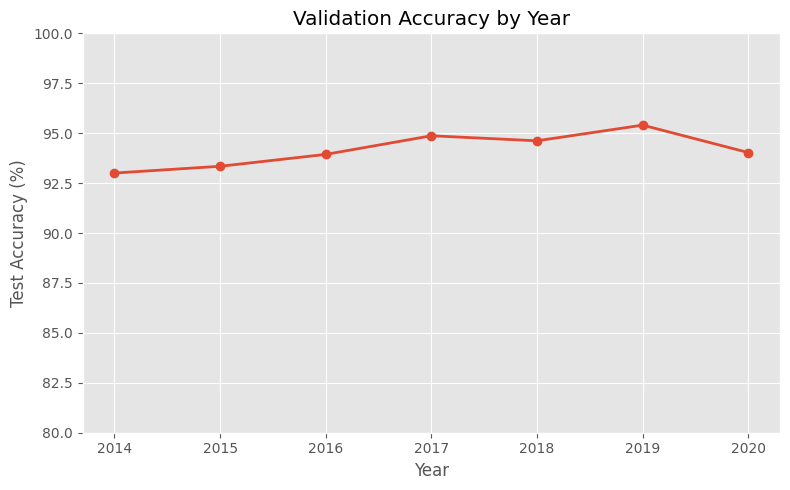

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(list(val_acc_history.keys()),
         list(val_acc_history.values()),
         marker='o',linestyle='-', linewidth=2)
plt.title('Validation Accuracy by Year')
plt.xlabel('Year')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.ylim(80, 100)
plt.xticks(list(val_acc_history.keys()))
plt.tight_layout()
plt.show()